In [ ]:
import math
import time
import random
from dataclasses import dataclass
from pathlib import Path
import torchaudio.functional as F
from typing import List, Dict, Tuple
import sys
import soundfile as sf
import pandas as pd
import numpy as np
import torch
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from transformers import (
    WhisperProcessor,
    WhisperForConditionalGeneration,
    get_linear_schedule_with_warmup,
)
from peft import LoraConfig, get_peft_model

In [ ]:
def load_audio(filepath, target_sr=16000):
    waveform_np, sr = sf.read(filepath, dtype="float32")  

    waveform = torch.from_numpy(waveform_np)
    if waveform.ndim == 1:
        waveform = waveform.unsqueeze(0) 
    elif waveform.ndim == 2:
        waveform = waveform.transpose(0, 1)

    # Resample if needed
    if sr != target_sr:
        waveform = F.resample(waveform, sr, target_sr)
        sr = target_sr

    return waveform, sr

In [ ]:

try:
    import editdistance  
except ImportError:
    editdistance = None


def _levenshtein(seq_a, seq_b):
    dp = list(range(len(seq_b) + 1))
    for i, ca in enumerate(seq_a, 1):
        prev = dp[0]
        dp[0] = i
        for j, cb in enumerate(seq_b, 1):
            cur = dp[j]
            dp[j] = min(
                dp[j] + 1,          
                dp[j - 1] + 1,      
                prev + (ca != cb),  
            )
            prev = cur
    return dp[-1]


def _edit_distance(a, b):
    if editdistance is not None:
        return editdistance.eval(a, b)
    return _levenshtein(a, b)


def compute_cer(reference, hypothesis):
    if isinstance(reference, list):
        if not isinstance(hypothesis, list) or len(reference) != len(hypothesis):
            raise ValueError('reference and hypothesis must be lists of the same length')
        if len(reference) == 0:
            return 0.0
        return float(np.mean([compute_cer(r, h) for r, h in zip(reference, hypothesis)]))
    if len(reference) == 0:
        return 0.0 if len(hypothesis) == 0 else 1.0
    distance = _edit_distance(reference, hypothesis)
    return distance / len(reference)


def compute_wer(reference, hypothesis):
    if isinstance(reference, list):
        if not isinstance(hypothesis, list) or len(reference) != len(hypothesis):
            raise ValueError('reference and hypothesis must be lists of the same length')
        if len(reference) == 0:
            return 0.0
        return float(np.mean([compute_wer(r, h) for r, h in zip(reference, hypothesis)]))
    ref_words = reference.split()
    hyp_words = hypothesis.split()
    if len(ref_words) == 0:
        return 0.0 if len(hyp_words) == 0 else 1.0
    distance = _edit_distance(ref_words, hyp_words)
    return distance / len(ref_words)




def evaluate_loss(model, dloader: DataLoader, device: str) -> float:
    model.eval()
    total_loss = 0.0
    n_batches = 0
    with torch.no_grad():
        for batch in tqdm(dloader, desc="Eval loss", leave=False):
            input_features = batch['input_features'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            loss = model(input_features=input_features, attention_mask=attention_mask, labels=labels).loss
            total_loss += loss.item()
            n_batches += 1
    return total_loss / max(1, n_batches)


def run_eval(model, processor: WhisperProcessor, dloader: DataLoader, split_name: str, device: str):
    model.eval()
    refs, hyps = [], []
    with torch.no_grad():
        for batch in tqdm(dloader, desc=f"Eval {split_name}", leave=False):
            input_features = batch['input_features'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels']
            generated_ids = model.generate(
                input_features=input_features,
                attention_mask=attention_mask,
                language="id",
                task="transcribe",
            )
            transcripts = processor.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
            label_ids = labels.clone()
            label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
            ref_texts = processor.tokenizer.batch_decode(label_ids, skip_special_tokens=True)
            refs.extend(ref_texts)
            hyps.extend(transcripts)
    wer = compute_wer(refs, hyps)
    cer = compute_cer(refs, hyps)
    avg_score = 0.5 * (wer + cer)
    print(f"{split_name} WER: {wer:.4f} | CER: {cer:.4f} | Avg: {avg_score:.4f}")
    return wer, cer, avg_score

class WhisperAudioDataset(Dataset):
    def __init__(self, df: pd.DataFrame):
        self.df = df.reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        waveform, sr = load_audio(row['AudioPath'], target_sr=16000)
        waveform = waveform.mean(0)
        return {
            'audio': waveform,
            'sampling_rate': sr,
            'text': row['Transcript'],
            'sentence_id': row['SentenceID'],
        }


def make_collate_fn(processor: WhisperProcessor):
    max_length = processor.feature_extractor.n_samples
    def collate(batch: List[Dict]):
        audios = [b['audio'].squeeze().cpu().numpy() for b in batch]
        texts = [b['text'] for b in batch]
        inputs = processor(
            audios,
            sampling_rate=16000,
            return_tensors='pt',
            padding='max_length',
            max_length=max_length,
            truncation=True,
            return_attention_mask=True,
        )
        labels = processor.tokenizer(
            texts,
            return_tensors='pt',
            padding=True,
        )
        labels['input_ids'][labels['input_ids'] == processor.tokenizer.pad_token_id] = -100
        return {
            'input_features': inputs.input_features,
            'attention_mask': inputs.attention_mask,
            'labels': labels['input_ids'],
        }
    return collate


def load_splits(csv_path: str = '../sorted_data.csv') -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    df = pd.read_csv(csv_path)
    if 'Split' not in df.columns:
        raise ValueError("sorted_data.csv missing 'Split' column. Re-run data_sorting.py to add Split labels.")
    train_df = df[df['Split'] == 'train'].copy()
    val_df = df[df['Split'] == 'val'].copy()
    test_df = df[df['Split'] == 'test'].copy()
    return train_df, val_df, test_df

def count_trainable_params(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Trainable params: {trainable/1e6:.2f}M / {total/1e6:.2f}M total")
    return trainable, total



In [4]:

@dataclass
class TrainConfig:
    model_name: str = "openai/whisper-small"  
    batch_size: int = 8
    num_epochs: int = 20
    lr: float = 1e-5
    seed: int = 42
    patience: int = 5
    use_lora: bool = False
    lora_r: int = 32
    lora_alpha: int = 64
    lora_dropout: float = 0.05
    lora_target_modules: list = None
    device: str = "cuda" if torch.cuda.is_available() else "cpu"


def set_seed(seed: int):
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


def train_and_eval(config: TrainConfig):
    set_seed(config.seed)
    start_time = time.time()
    device_name = torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'

    train_df, val_df, test_df = load_splits()
    print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")
    print(f"Using device: {config.device} ({device_name})")

    processor = WhisperProcessor.from_pretrained(config.model_name)
    model = WhisperForConditionalGeneration.from_pretrained(config.model_name)
    model.generation_config.language = "id"

    if config.use_lora:
        lora_cfg = LoraConfig(
            r=config.lora_r,
            lora_alpha=config.lora_alpha,
            lora_dropout=config.lora_dropout,
            target_modules=["q_proj", "v_proj"],
            bias="none",
        )
        model = get_peft_model(model, lora_cfg)
        model.print_trainable_parameters()
    trainable_params, total_params = count_trainable_params(model)
    model.to(config.device)

    train_ds = WhisperAudioDataset(train_df)
    val_ds = WhisperAudioDataset(val_df)
    test_ds = WhisperAudioDataset(test_df)

    collate_fn = make_collate_fn(processor)
    train_loader = DataLoader(train_ds, batch_size=config.batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_ds, batch_size=config.batch_size, shuffle=False, collate_fn=collate_fn)
    test_loader = DataLoader(test_ds, batch_size=config.batch_size, shuffle=False, collate_fn=collate_fn)

    optimizer = torch.optim.AdamW(model.parameters(), lr=config.lr)
    total_steps = len(train_loader) * config.num_epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(0.1 * total_steps),
        num_training_steps=total_steps,
    )

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_epoch = 0
    epochs_no_improve = 0

    for epoch in range(config.num_epochs):
        model.train()
        running_loss = 0.0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{config.num_epochs}", leave=False)
        for step, batch in enumerate(pbar, 1):
            optimizer.zero_grad()
            input_features = batch['input_features'].to(config.device)
            attention_mask = batch['attention_mask'].to(config.device)
            labels = batch['labels'].to(config.device)
            loss = model(input_features=input_features, attention_mask=attention_mask, labels=labels).loss
            loss.backward()
            optimizer.step()
            scheduler.step()
            running_loss += loss.item()
            if step % 10 == 0 or step == 1:
                pbar.set_postfix(loss=running_loss / step)
        avg_loss = running_loss / max(1, len(train_loader))
        train_losses.append(avg_loss)
        val_loss = evaluate_loss(model, val_loader, config.device)
        val_losses.append(val_loss)
        print(f"Epoch {epoch+1}/{config.num_epochs} | Train loss: {avg_loss:.4f} | Val loss: {val_loss:.4f}")

        if val_loss < best_val_loss - 1e-6:
            best_val_loss = val_loss
            best_epoch = epoch + 1
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= config.patience:
                print(f"Early stopping at epoch {epoch+1} (no val improvement for {config.patience} epochs). Best val loss {best_val_loss:.4f} at epoch {best_epoch}.")
                break

    elapsed = time.time() - start_time
    print(f"Total train+eval time: {elapsed/60:.2f} min ({elapsed:.1f} s) on {device_name}")
    print(f"Best val loss: {best_val_loss:.4f} at epoch {best_epoch}")

    metrics = []
    for epoch_idx, (tr_loss, vl_loss) in enumerate(zip(train_losses, val_losses), start=1):
        metrics.append({
            'epoch': epoch_idx,
            'train_loss': tr_loss,
            'val_loss': vl_loss,
            'model': config.model_name,
            'batch_size': config.batch_size,
            'lr': config.lr,
            'num_epochs': config.num_epochs,
            'seed': config.seed,
            'patience': config.patience,
            'device': device_name,
            'use_lora': config.use_lora,
            'lora_r': config.lora_r,
            'lora_alpha': config.lora_alpha,
            'lora_dropout': config.lora_dropout,
            'trainable_params': trainable_params,
            'total_params': total_params,
        })
    csv_name = f"metrics_{config.model_name.replace('/', '-')}"         f"_bs{config.batch_size}_lr{config.lr}_ep{config.num_epochs}_pat{config.patience}_lora{int(config.use_lora)}_seed{config.seed}.csv"
    pd.DataFrame(metrics).to_csv(csv_name, index=False)
    print(f"Saved per-epoch metrics to {csv_name}")

    return train_losses, val_losses, processor, model, (train_loader, val_loader, test_loader), device_name


In [5]:
cfg = TrainConfig()
train_losses, val_losses, processor, model, (train_loader, val_loader, test_loader), device_name = train_and_eval(cfg)

Train: 1470 | Val: 210 | Test: 410
Using device: cuda (NVIDIA GeForce RTX 5090)
Trainable params: 240.58M / 241.73M total


Epoch 1/20:   0%|          | 0/184 [00:00<?, ?it/s]

Eval loss:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 1/20 | Train loss: 3.2922 | Val loss: 1.8284


Epoch 2/20:   0%|          | 0/184 [00:00<?, ?it/s]

Eval loss:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 2/20 | Train loss: 1.3132 | Val loss: 1.1153


Epoch 3/20:   0%|          | 0/184 [00:00<?, ?it/s]

Eval loss:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 3/20 | Train loss: 0.3570 | Val loss: 0.5207


Epoch 4/20:   0%|          | 0/184 [00:00<?, ?it/s]

Eval loss:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 4/20 | Train loss: 0.0929 | Val loss: 0.4930


Epoch 5/20:   0%|          | 0/184 [00:00<?, ?it/s]

Eval loss:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 5/20 | Train loss: 0.0451 | Val loss: 0.5052


Epoch 6/20:   0%|          | 0/184 [00:00<?, ?it/s]

Eval loss:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 6/20 | Train loss: 0.0235 | Val loss: 0.5043


Epoch 7/20:   0%|          | 0/184 [00:00<?, ?it/s]

Eval loss:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 7/20 | Train loss: 0.0140 | Val loss: 0.5094


Epoch 8/20:   0%|          | 0/184 [00:00<?, ?it/s]

Eval loss:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 8/20 | Train loss: 0.0094 | Val loss: 0.5166


Epoch 9/20:   0%|          | 0/184 [00:00<?, ?it/s]

Eval loss:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 9/20 | Train loss: 0.0072 | Val loss: 0.5201
Early stopping at epoch 9 (no val improvement for 5 epochs). Best val loss 0.4930 at epoch 4.
Total train+eval time: 22.81 min (1368.5 s) on NVIDIA GeForce RTX 5090
Best val loss: 0.4930 at epoch 4
Saved per-epoch metrics to metrics_openai-whisper-small_bs8_lr1e-05_ep20_pat5_lora0_seed42.csv


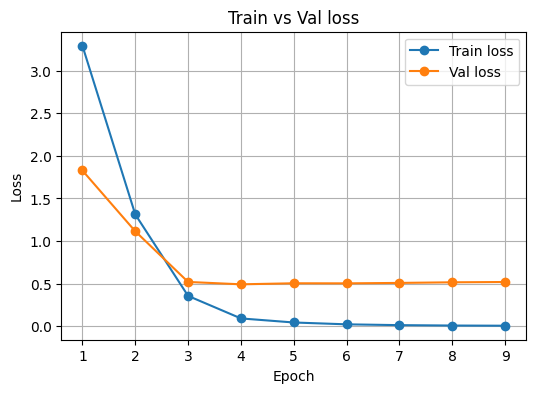

In [6]:
if not train_losses:
    print("No losses to plot. Re-run training; check for errors above.")
else:
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(6, 4))
    plt.plot(epochs, train_losses, label="Train loss", marker="o")
    plt.plot(epochs, val_losses, label="Val loss", marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Train vs Val loss")
    plt.grid(True)
    plt.legend()
    plt.show()

In [ ]:
test_wer, test_cer, test_avg = run_eval(model, processor, test_loader, "Test", cfg.device)
print(f"Test WER: {test_wer:.4f} | CER: {test_cer:.4f} | Avg: {test_avg:.4f}")


Eval Test:   0%|          | 0/52 [00:00<?, ?it/s]

Test WER: 0.3168 | CER: 0.0877 | Avg: 0.2022
Test WER: 0.3168 | CER: 0.0877 | Avg: 0.2022


Train: 1470 | Val: 210 | Test: 410
Using device: cuda (NVIDIA GeForce RTX 5090)
Trainable params: 240.58M / 241.73M total


Epoch 1/20:   0%|          | 0/92 [00:00<?, ?it/s]

Eval loss:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 1/20 | Train loss: 3.7364 | Val loss: 2.0456


Epoch 2/20:   0%|          | 0/92 [00:00<?, ?it/s]

Eval loss:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 2/20 | Train loss: 1.5644 | Val loss: 1.4354


Epoch 3/20:   0%|          | 0/92 [00:00<?, ?it/s]

Eval loss:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 3/20 | Train loss: 0.9422 | Val loss: 1.0131


Epoch 4/20:   0%|          | 0/92 [00:00<?, ?it/s]

Eval loss:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 4/20 | Train loss: 0.2955 | Val loss: 0.5161


Epoch 5/20:   0%|          | 0/92 [00:00<?, ?it/s]

Eval loss:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 5/20 | Train loss: 0.0809 | Val loss: 0.5114


Epoch 6/20:   0%|          | 0/92 [00:00<?, ?it/s]

Eval loss:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 6/20 | Train loss: 0.0447 | Val loss: 0.5091


Epoch 7/20:   0%|          | 0/92 [00:00<?, ?it/s]

Eval loss:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 7/20 | Train loss: 0.0269 | Val loss: 0.5166


Epoch 8/20:   0%|          | 0/92 [00:00<?, ?it/s]

Eval loss:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 8/20 | Train loss: 0.0181 | Val loss: 0.5215


Epoch 9/20:   0%|          | 0/92 [00:00<?, ?it/s]

Eval loss:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 9/20 | Train loss: 0.0138 | Val loss: 0.5251


Epoch 10/20:   0%|          | 0/92 [00:00<?, ?it/s]

Eval loss:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 10/20 | Train loss: 0.0113 | Val loss: 0.5300


Epoch 11/20:   0%|          | 0/92 [00:00<?, ?it/s]

Eval loss:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 11/20 | Train loss: 0.0096 | Val loss: 0.5306
Early stopping at epoch 11 (no val improvement for 5 epochs). Best val loss 0.5091 at epoch 6.
Total train+eval time: 30.40 min (1823.8 s) on NVIDIA GeForce RTX 5090
Best val loss: 0.5091 at epoch 6
Saved per-epoch metrics to metrics_openai-whisper-small_bs16_lr1e-05_ep20_pat5_lora0_seed42.csv


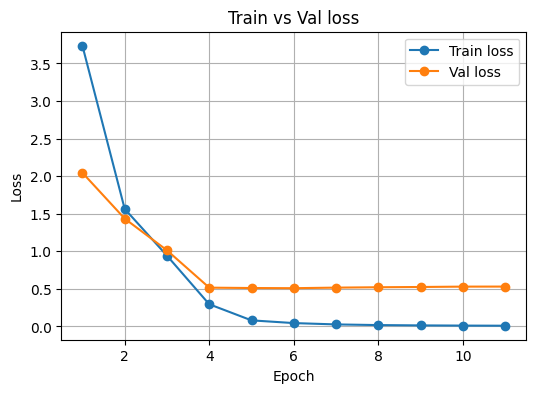

In [8]:
@dataclass
class TrainConfig:
    model_name: str = "openai/whisper-small"  
    batch_size: int = 16
    num_epochs: int = 20
    lr: float = 1e-5
    seed: int = 42
    patience: int = 5
    use_lora: bool = False
    lora_r: int = 32
    lora_alpha: int = 64
    lora_dropout: float = 0.05
    lora_target_modules: list = None
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
cfg = TrainConfig()
train_losses, val_losses, processor, model, (train_loader, val_loader, test_loader), device_name = train_and_eval(cfg)
if not train_losses:
    print("No losses to plot. Re-run training; check for errors above.")
else:
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(6, 4))
    plt.plot(epochs, train_losses, label="Train loss", marker="o")
    plt.plot(epochs, val_losses, label="Val loss", marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Train vs Val loss")
    plt.grid(True)
    plt.legend()
    plt.show()

In [ ]:
test_wer, test_cer, test_avg = run_eval(model, processor, test_loader, "Test", cfg.device)
print(f"Test WER: {test_wer:.4f} | CER: {test_cer:.4f} | Avg: {test_avg:.4f}")

Eval Test:   0%|          | 0/26 [00:00<?, ?it/s]

Test WER: 0.3227 | CER: 0.0909 | Avg: 0.2068
Test WER: 0.3227 | CER: 0.0909 | Avg: 0.2068


Train: 1470 | Val: 210 | Test: 410
Using device: cuda (NVIDIA GeForce RTX 5090)
trainable params: 3,538,944 || all params: 245,273,856 || trainable%: 1.4429
Trainable params: 3.54M / 245.27M total


Epoch 1/20:   0%|          | 0/368 [00:00<?, ?it/s]

Eval loss:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 1/20 | Train loss: 5.9219 | Val loss: 4.1770


Epoch 2/20:   0%|          | 0/368 [00:00<?, ?it/s]

Eval loss:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 2/20 | Train loss: 3.0466 | Val loss: 2.4826


Epoch 3/20:   0%|          | 0/368 [00:00<?, ?it/s]

Eval loss:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 3/20 | Train loss: 2.2442 | Val loss: 2.1741


Epoch 4/20:   0%|          | 0/368 [00:00<?, ?it/s]

Eval loss:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 4/20 | Train loss: 1.9880 | Val loss: 2.0033


Epoch 5/20:   0%|          | 0/368 [00:00<?, ?it/s]

Eval loss:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 5/20 | Train loss: 1.8225 | Val loss: 1.8751


Epoch 6/20:   0%|          | 0/368 [00:00<?, ?it/s]

Eval loss:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 6/20 | Train loss: 1.6632 | Val loss: 1.7226


Epoch 7/20:   0%|          | 0/368 [00:00<?, ?it/s]

Eval loss:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 7/20 | Train loss: 1.4492 | Val loss: 1.0839


Epoch 8/20:   0%|          | 0/368 [00:00<?, ?it/s]

Eval loss:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 8/20 | Train loss: 0.7232 | Val loss: 0.8693


Epoch 9/20:   0%|          | 0/368 [00:00<?, ?it/s]

Eval loss:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 9/20 | Train loss: 0.6469 | Val loss: 0.8581


Epoch 10/20:   0%|          | 0/368 [00:00<?, ?it/s]

Eval loss:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 10/20 | Train loss: 0.6173 | Val loss: 0.8359


Epoch 11/20:   0%|          | 0/368 [00:00<?, ?it/s]

Eval loss:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 11/20 | Train loss: 0.5917 | Val loss: 0.8263


Epoch 12/20:   0%|          | 0/368 [00:00<?, ?it/s]

Eval loss:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 12/20 | Train loss: 0.5668 | Val loss: 0.8101


Epoch 13/20:   0%|          | 0/368 [00:00<?, ?it/s]

Eval loss:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 13/20 | Train loss: 0.5473 | Val loss: 0.8064


Epoch 14/20:   0%|          | 0/368 [00:00<?, ?it/s]

Eval loss:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 14/20 | Train loss: 0.5319 | Val loss: 0.7982


Epoch 15/20:   0%|          | 0/368 [00:00<?, ?it/s]

Eval loss:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 15/20 | Train loss: 0.5213 | Val loss: 0.7883


Epoch 16/20:   0%|          | 0/368 [00:00<?, ?it/s]

Eval loss:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 16/20 | Train loss: 0.5072 | Val loss: 0.7856


Epoch 17/20:   0%|          | 0/368 [00:00<?, ?it/s]

Eval loss:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 17/20 | Train loss: 0.4970 | Val loss: 0.7828


Epoch 18/20:   0%|          | 0/368 [00:00<?, ?it/s]

Eval loss:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 18/20 | Train loss: 0.4909 | Val loss: 0.7790


Epoch 19/20:   0%|          | 0/368 [00:00<?, ?it/s]

Eval loss:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 19/20 | Train loss: 0.4855 | Val loss: 0.7774


Epoch 20/20:   0%|          | 0/368 [00:00<?, ?it/s]

Eval loss:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 20/20 | Train loss: 0.4810 | Val loss: 0.7769
Total train+eval time: 52.27 min (3136.4 s) on NVIDIA GeForce RTX 5090
Best val loss: 0.7769 at epoch 20
Saved per-epoch metrics to metrics_openai-whisper-small_bs4_lr1e-05_ep20_pat5_lora1_seed42.csv


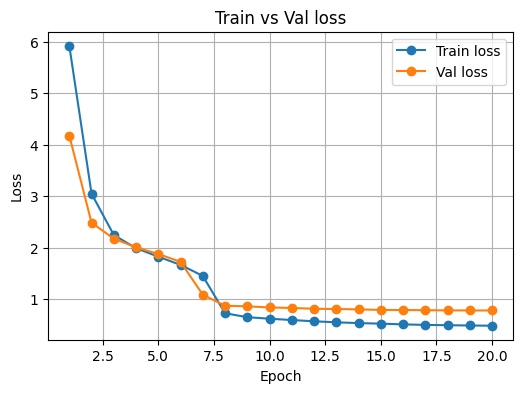

In [10]:
@dataclass
class TrainConfig:
    model_name: str = "openai/whisper-small"  
    batch_size: int = 4
    num_epochs: int = 20
    lr: float = 1e-5
    seed: int = 42
    patience: int = 5
    use_lora: bool = True
    lora_r: int = 32
    lora_alpha: int = 64
    lora_dropout: float = 0.05
    lora_target_modules: list = None
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
cfg = TrainConfig()
train_losses, val_losses, processor, model, (train_loader, val_loader, test_loader), device_name = train_and_eval(cfg)
if not train_losses:
    print("No losses to plot. Re-run training; check for errors above.")
else:
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(6, 4))
    plt.plot(epochs, train_losses, label="Train loss", marker="o")
    plt.plot(epochs, val_losses, label="Val loss", marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Train vs Val loss")
    plt.grid(True)
    plt.legend()
    plt.show()

In [ ]:
test_wer, test_cer, test_avg = run_eval(model, processor, test_loader, "Test", cfg.device)
print(f"Test WER: {test_wer:.4f} | CER: {test_cer:.4f} | Avg: {test_avg:.4f}")

Eval Test:   0%|          | 0/103 [00:00<?, ?it/s]

Test WER: 1.5752 | CER: 1.4087 | Avg: 1.4920
Test WER: 1.5752 | CER: 1.4087 | Avg: 1.4920
